In [37]:
import os,csv,json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import SimpleITK as sitk
import tifffile as tif

sys.path.append("/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe/")
from tools.analysis.transform_points import transform_points

In [90]:
basepath = "/home/emilyjanedennis/Desktop/brains/"
brainname = "z269"
brainpath = os.path.join(basepath,brainname)
channel = "ch00"
filename = "_ch00_cells_filtered.npy"
fullfilename = os.path.join(brainpath,filename)
fulldf = pd.DataFrame(np.load(fullfilename))
outputfolder= os.path.join(brainpath,"output_{}".format(channel))

#annotationvolume = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_toMRIr/result.tif"
#erosionmask = 
#annotationlabels = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/SIGMA_labels.csv"

FileNotFoundError: [Errno 2] No such file or directory: '/home/emilyjanedennis/Desktop/brains/z269/_ch00_cells_filtered.npy'

In [61]:
#only have to do once
os.mkdir(outputfolder)

In [62]:
fulldf = fulldf.apply(pd.to_numeric, errors='coerce')
fulldf.keys()

Index(['x', 'y', 'z', 'size', 'source'], dtype='object')

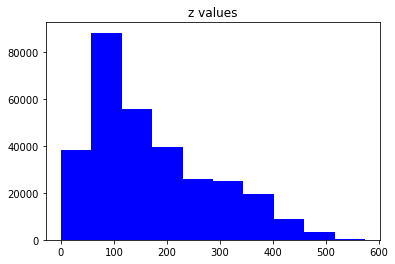

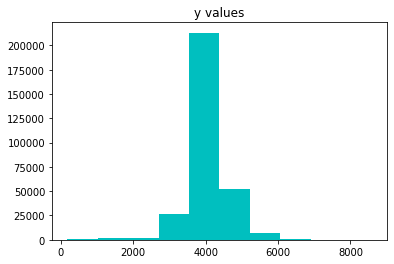

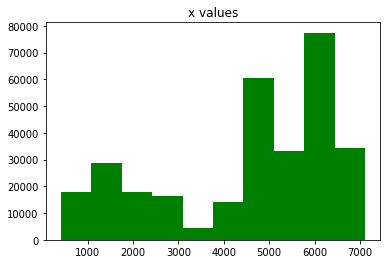

In [63]:
# plot summary data, helps make sure axes are correct and good to see 
subdf = fulldf[['z','y','x']]
npdf = subdf.to_numpy()
plt.hist(npdf[:,0],color='b')
plt.title('z values')
plt.show()
plt.hist(npdf[:,1],color='c')
plt.title('y values')
plt.show()
plt.hist(npdf[:,2],color='g')
plt.title('x values')
plt.show()

In [64]:
npdf_filename = "{}{}_pdf.npy".format(os.path.join(brainpath,brainname),channel)
np.save(npdf_filename,npdf)

In [65]:
transformfolder = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/MRIr_to_z269_ch01/"
transformfiles=[os.path.join(transformfolder,"TransformParameters.0.txt"),
                os.path.join(transformfolder,"TransformParameters.1.txt"),
                os.path.join(transformfolder,"TransformParameters.2.txt"),
                os.path.join(transformfolder,"TransformParameters.3.txt")]

# optional resampling between fullsized and input to elastix
original_dims = (7341, 8701, 606)  # sagittal original data
resample_dims = (591, 1006, 392)  # sagittal MRI atlas
resample_points = [original_dims, resample_dims]


In [66]:
transform_points(npdf_filename,outputfolder,transformfiles,resample_points)

This function assumes ZYX centers...
writing centers to transfomix input points text file......done writing centers

***********Starting Transformix***********b'\ntransformix is started at Sun Oct  4 18:23:50 2020.\n\nwhich transformix:   transformix\ntransformix runs at: emilyjanedennis-System-Product-Name\n  Linux 5.4.0-47-generic (x64), #51-Ubuntu SMP Fri Sep 4 19:50:52 UTC 2020\n  with 128513 MB memory, and 10 cores @ 1200 MHz.\nRunning transformix with parameter file "/home/emilyjanedennis/Desktop/brains/z269/output_ch01/order3_TransformParameters.3.txt".\n\nReading the elastix parameters from file ...\n\nInstalling all components.\nInstallingComponents was successful.\n\nELASTIX version: 5.000\nCommand line options from ElastixBase:\n-in       unspecified, so no input image specified\n-out      /home/emilyjanedennis/Desktop/brains/z269/output_ch01/\n-threads  unspecified, so all available threads are used\n-tp       /home/emilyjanedennis/Desktop/brains/z269/output_ch01/order3_Tra

In [68]:
transformed = np.load(os.path.join(outputfolder,"posttransformed_zyx_voxels.npy"))


annotation_volume_filename = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/tiffs/SIGMA_annotation_90um_edge_90um_vent_erosion.tif" 
annotation_volume=tif.imread(annotation_volume_filename)
annotation_labels = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/SIGMA_labels.csv"
labels = pd.read_csv(annotation_labels)

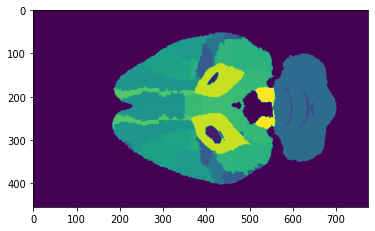

In [71]:
plt.imshow(annotation_volume[:,:,60])
plt.show()

In [72]:
transformed[1:10,:]

array([[271.047064, 390.250878,  12.895192],
       [271.605412, 382.809285,  13.134514],
       [271.805794, 389.808793,  12.958726],
       [273.15146 , 391.391564,  13.028251],
       [273.359671, 388.428202,  13.102162],
       [273.910063, 390.949838,  13.09439 ],
       [275.359935, 391.05204 ,  13.208007],
       [277.56991 , 390.710602,  13.396866],
       [270.987621, 390.384454,  14.564197]])

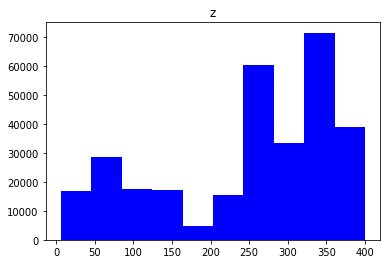

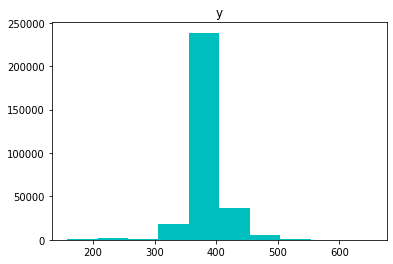

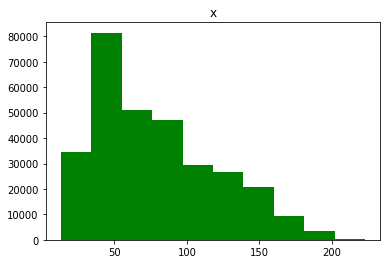

In [73]:
plt.hist(transformed[:,0],color='b')
plt.title("z")
plt.show()
plt.hist(transformed[:,1],color='c')
plt.title("y")
plt.show()
plt.hist(transformed[:,2],color='g')
plt.title("x")
plt.show()

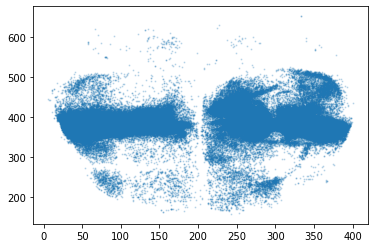

In [74]:
plt.scatter(transformed[:,0],transformed[:,1],s=1,alpha=0.2)
plt.show()

In [75]:
floort = np.floor(transformed)

In [76]:
masked_data = np.zeros(np.shape(annotation_volume))

In [77]:
floortcopy=floort
np.max(floortcopy[:,0])

400.0

In [78]:
floort=floort[floort[:,0]<454]
floort=floort[floort[:,1]<773]
floort=floort[floort[:,2]<301]
floort=floort[floort[:,0]>0]
floort=floort[floort[:,1]>0]
floort=floort[floort[:,2]>0]

In [79]:
# for each row in transformed, place the value in edgevent in the correct space
for i in np.arange(0,np.shape(floort)[0]-1):
    x,y,z=floort[i,:]
    z=z.astype(int)
    y=y.astype(int)
    x=x.astype(int)
    if annotation_volume[x,y,z]>0:
        masked_data[x,y,z] = annotation_volume[x,y,z]

In [80]:
tif.imsave(os.path.join(brainpath,"{}eroded_results.tif".format(brainname)),masked_data)

In [81]:
reshaped_masked=masked_data.reshape(np.size(masked_data),1)
np.shape(reshaped_masked)

(106355340, 1)

In [82]:
reshaped_masked=reshaped_masked[reshaped_masked>0]
max_masked = np.max(reshaped_masked)

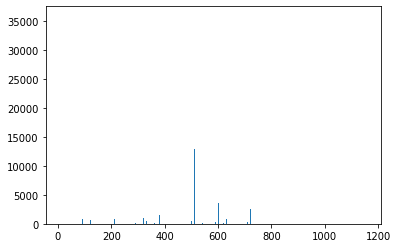

In [83]:
histinfo =plt.hist(reshaped_masked,bins=max_masked.astype(int))
plt.show()

In [84]:
labels.insert(3,'histinfo',0)

In [85]:
labels

,atlas,ID,label,histinfo
0,SIGMA,1171,Ventricular System,0
1,Waxholm,171,Globus Pallidus,0
2,Waxholm,731,Striatum,0
3,Waxholm,221,Granule Cell Level of the Cerebellum,0
4,Waxholm,341,Molecular Layer of the Cerebellum,0
...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,0
230,Waxholm,902,Deeper Layers of the Superior Colliculus,0
231,Waxholm,1082,SP5,0
232,Waxholm,792,Anterior Commissure Intrabulbar part,0


In [86]:
for i in np.arange(1,max_masked.astype(int)):
    labels.histinfo[labels.ID==i]=histinfo[0][i]

/home/emilyjanedennis/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
labels

,atlas,ID,label,histinfo
0,SIGMA,1171,Ventricular System,0
1,Waxholm,171,Globus Pallidus,2
2,Waxholm,731,Striatum,0
3,Waxholm,221,Granule Cell Level of the Cerebellum,0
4,Waxholm,341,Molecular Layer of the Cerebellum,0
...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,0
230,Waxholm,902,Deeper Layers of the Superior Colliculus,0
231,Waxholm,1082,SP5,0
232,Waxholm,792,Anterior Commissure Intrabulbar part,0


In [88]:
histinfo

(array([ 3., 49.,  0., ...,  0.,  0.,  1.]),
 array([  11.        ,   11.99045139,   12.98090278, ..., 1150.01909722,
        1151.00954861, 1152.        ]),
 <BarContainer object of 1152 artists>)

In [89]:
labels.to_csv('/home/emilyjanedennis/Desktop/z269_ch01_counts_SIGMA_90eroded.csv')